### Data Collection

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import train_test_split
import category_encoders as ce
# import requests
import time
import datetime
from sklearn.preprocessing import StandardScaler
from IPython.display import Image, display

In [2]:
# Read the data
data = pd.read_csv('../real_estate_data/Real_Estate_Sales_2001-2020.csv', low_memory=False)

# View the data
data.head() 

,Serial Number,List Year,Date Recorded,Town,Address,Assessed Value,Sale Amount,Sales Ratio,Property Type,Residential Type,Non Use Code,Assessor Remarks,OPM remarks,Location
0,2020177,2020,04/14/2021,Ansonia,323 BEAVER ST,133000.0,248400.0,0.5354,Residential,Single Family,NaN,NaN,NaN,POINT (-73.06822 41.35014)
1,2020225,2020,05/26/2021,Ansonia,152 JACKSON ST,110500.0,239900.0,0.4606,Residential,Three Family,NaN,NaN,NaN,NaN
2,2020348,2020,09/13/2021,Ansonia,230 WAKELEE AVE,150500.0,325000.0,0.4630,Commercial,NaN,NaN,NaN,NaN,NaN
3,2020090,2020,12/14/2020,Ansonia,57 PLATT ST,127400.0,202500.0,0.6291,Residential,Two Family,NaN,NaN,NaN,NaN
4,200500,2020,09/07/2021,Avon,245 NEW ROAD,217640.0,400000.0,0.5441,Residential,Single Family,NaN,NaN,NaN,NaN


**Notes:**
- Number of total observations: 997,213
- Date range: 2001-2020
- Number of observations with 'Date Recorded' in 2021: 48,441

In [3]:
# Read the data
mill_rates = pd.read_csv('../real_estate_data/Mill-Rates_FY2014-2024.csv')

# View the data
mill_rates.head()

,Grand List Year,Fiscal Year,Town Code,Service District Code,Municipality/District,Mill Rate,Mill Rate - Real & Personal Property,Mill Rate - Motor Vehicle,Flat Rate Fee / Other Rate
0,2019,2021,1.0,1,Andover,NaN,35.610,35.610,NaN
1,2019,2021,2.0,2,Ansonia,NaN,37.800,37.800,NaN
2,2019,2021,3.0,3,Ashford,NaN,36.836,36.836,NaN
3,2019,2021,3.0,NaN,Ashford - Lake Chaffee Improvement Association...,NaN,NaN,NaN,212
4,2019,2021,4.0,4,Avon,NaN,32.900,32.900,NaN


**Notes:**

- Number of total observations: 4,117
- Date range: 2012-2022 ('Grand List Year')
- Number of observations with 'Grand List Year' in 2021: 482

### Data Cleaning

#### Real Estate Sales Data

In [4]:
### Rename the columns
data.columns = [col.lower().replace(' ','_') for col in data.columns]

In [5]:
### Data type conversions

# serial_number - no change
# list_year - no change
# date_recorded --> no change
# town --> no change
# address --> no change

# assessed_value --> int
data['assessed_value'] = data['assessed_value'].astype(int)

# sale_amount --> int
data['sale_amount'] = data['sale_amount'].astype(int)

# sales_ratio - no change
# property_type - no change
# residential_type - no change
# non_use_code - no change
# assessor_remarks - no change
# opm_remarks - no change
# location - no change

# View converted data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997213 entries, 0 to 997212
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   serial_number     997213 non-null  int64  
 1   list_year         997213 non-null  int64  
 2   date_recorded     997211 non-null  object 
 3   town              997213 non-null  object 
 4   address           997162 non-null  object 
 5   assessed_value    997213 non-null  int64  
 6   sale_amount       997213 non-null  int64  
 7   sales_ratio       997213 non-null  float64
 8   property_type     614767 non-null  object 
 9   residential_type  608904 non-null  object 
 10  non_use_code      289681 non-null  object 
 11  assessor_remarks  149864 non-null  object 
 12  opm_remarks       9934 non-null    object 
 13  location          197697 non-null  object 
dtypes: float64(1), int64(4), object(9)
memory usage: 106.5+ MB


In [6]:
### Remove rows where missing values < 1% of data set

# Remove rows for 'address'
subset_1 = data.loc[data['address'].isnull()]
data.drop(index=subset_1.index, inplace=True)

# Remove rows for 'date_recorded'
subset_2 = data.loc[data['date_recorded'].isnull()]
data.drop(index=subset_2.index, inplace=True)

In [7]:
### Imputations

# Impute null values with 'None'
data['opm_remarks'].fillna('None', inplace=True)
data['assessor_remarks'].fillna('None', inplace=True)
data['non_use_code'].fillna('None', inplace=True)

# Impute null values with ''
data['location'].fillna('', inplace=True)

# Impute null values with 'Other'
data['residential_type'].fillna('Other', inplace=True)
data['property_type'].fillna('Other', inplace=True)

# Check missing values
data.isnull().sum().sort_values(ascending=False)

serial_number       0
list_year           0
date_recorded       0
town                0
address             0
assessed_value      0
sale_amount         0
sales_ratio         0
property_type       0
residential_type    0
non_use_code        0
assessor_remarks    0
opm_remarks         0
location            0
dtype: int64

In [8]:
### Create new columns + remove rows with missing data

## Create 'full_address'
data['full_address'] = data['address'] + ', ' + data['town'] + ', CT'

## Define a regular expression for 'location'
pattern = r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)'

# Create 'longitude' + 'latitude'
data[['longitude', 'latitude']] = data['location'].str.extract(pattern)

# Remove rows that have missing data for 'longitude'
data = data.loc[~(data['longitude'].isnull()) & ~(data['latitude'].isnull())].copy()

**Note:**
    
- Number of observations: 197,691

In [9]:
# # Define a function that converts address to latitude/longitude using 
# # OpenStreetMap API
# def geocode_address(address):
#     osm_api_url = f'https://nominatim.openstreetmap.org/search?format=json&q={address}'
#     response = requests.get(osm_api_url)
#     if response.status_code == 200:
#         data = response.json()
#         if data:
#             lat = float(data[0]['lat'])
#             lon = float(data[0]['lon'])
#             return lat, lon
#         else:
#             return -1, -1
#     else:
#         return -1, -1

#### Mill Rates Data

In [10]:
### Rename the columns
mill_rates.columns = [col.lower().replace(' ','_') for col in mill_rates.columns]

In [11]:
### Drop unneeded columns + rows

# Drop unneeded columns
mill_rates.drop(columns=['fiscal_year', 'town_code', 
                         'service_district_code', 'mill_rate',
                         'mill_rate_-_motor_vehicle', 
                         'flat_rate_fee_/_other_rate'], inplace=True)                    

# Rename 'mill_rate_-_real_&_personal_property'
mill_rates.rename(columns={'mill_rate_-_real_&_personal_property': 'mill_rate_property'}, inplace=True)

# Drop rows to limit data to 2021 and under
mr = mill_rates.loc[mill_rates['grand_list_year'] < 2022]

In [12]:
### Data type conversions - None needed

# Check data types
mr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3625 entries, 0 to 3624
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   grand_list_year        3625 non-null   int64  
 1   municipality/district  3625 non-null   object 
 2   mill_rate_property     1370 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 113.3+ KB


In [13]:
### Handle missing values

# Create pivot table to fill in null values
mr_pivot = mr.pivot(index=['municipality/district'],
          columns='grand_list_year',
          values='mill_rate_property').ffill(axis=1)

# Reset index to create 'municipality' column
mr_df = mr_pivot.reset_index()

# Select relevant columns
mr_df = mr_df.iloc[:, [0]+[-1]]

# Drop all null rows
mr_df.dropna(axis=0, inplace=True)

### Data Preparation

In [14]:
# Convert 'date_recorded' to datetime object
data['date_recorded'] = pd.to_datetime(data['date_recorded'])

# Limit 'data' to 'date_recorded' entries in 2021
data = data.loc[(data['date_recorded'] > pd.to_datetime('2020-12-31')) & \
        (data['date_recorded'] < pd.to_datetime('2022-01-01'))].copy()

In [15]:
# Merge 'data' with 'mr_df'
merged_df = pd.merge(data, mr_df, left_on='town', right_on='municipality/district',
        how='left')

In [16]:
# Drop duplicate column
merged_df.drop(columns='municipality/district', inplace=True)

# Rename column to 'mill_rate'
merged_df.rename(columns={2021: 'mill_rate'}, inplace=True)

**Notes:**

- Number of observations: 21,747

In [17]:
# # Randomly sample 2500 observations
# final_data = merged_df.sample(n=2500, replace=False, random_state=42)

In [18]:
# ### Requires 1624.42 seconds (~30 minutes) to run

# # Start time
# start_time = time.time()

# # Create 'coordinates' 
# final_data['coordinates'] = final_data['full_address'].apply(geocode_address)

# # End time
# elapsed_time = time.time() - start_time
# print(f'Elapsed time to compute: {elapsed_time} seconds')

In [19]:
# ### Split 'coordinates' into 'latitude' and 'longitude' columns
# final_data[['latitude', 'longitude']] = final_data['coordinates'].apply(pd.Series)

In [20]:
# ### Save the data
# final_data.to_csv('../real_estate_data/cleaned_data.csv')

In [21]:
### Save the data
merged_df.to_csv('../real_estate_data/cleaned_data.csv')

In [22]:
### Read the cleaned_data
cleaned_data = pd.read_csv('../real_estate_data/cleaned_data.csv')

# Drop unneeded columns
cleaned_data.drop(columns=['Unnamed: 0', 'list_year',
                          'location'], inplace=True)

# # Drop rows where 'latitude' or 'longitude' == -1.0
# cleaned_data = cleaned_data.loc[(cleaned_data['latitude'] != -1.0) | (cleaned_data['longitude'] != -1.0)]

# View the cleaned_data
cleaned_data.head()

,serial_number,date_recorded,town,address,assessed_value,sale_amount,sales_ratio,property_type,residential_type,non_use_code,assessor_remarks,opm_remarks,full_address,longitude,latitude,mill_rate
0,2020177,2021-04-14,Ansonia,323 BEAVER ST,133000,248400,0.5354,Residential,Single Family,None,None,None,"323 BEAVER ST, Ansonia, CT",-73.06822,41.35014,37.80
1,20188,2021-07-19,Burlington,206 COVEY RD,286860,540000,0.5312,Residential,Single Family,None,None,None,"206 COVEY RD, Burlington, CT",-72.97635,41.79258,32.70
2,200192,2021-05-10,East Haddam,96 LONGWOOD DR,83020,175000,0.4744,Residential,Single Family,None,None,None,"96 LONGWOOD DR, East Haddam, CT",-72.33294,41.51729,31.79
3,200372,2021-04-05,East Haven,75 REDWOOD DR #704,89580,165000,0.5429,Residential,Condo,None,None,None,"75 REDWOOD DR #704, East Haven, CT",-72.84836,41.32761,31.20
4,200890,2021-04-22,Greenwich,188 BIBLE STREET,737590,1364000,0.5407,Residential,Single Family,None,None,None,"188 BIBLE STREET, Greenwich, CT",-73.59662,41.05717,11.28


**Notes:**

- Number of observations: 21,747

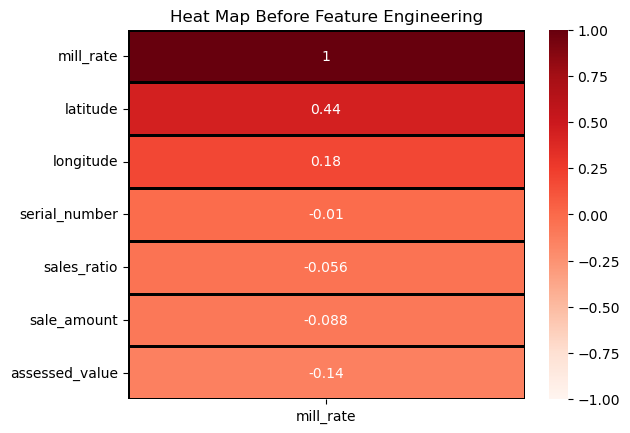

In [23]:
# Initial heat map of cleaned_data
plt.title('Heat Map Before Feature Engineering')
sns.heatmap(cleaned_data.select_dtypes('number').corr()[['mill_rate']] \
            .sort_values(by='mill_rate', ascending=False), cmap='Reds', \
            vmin=-1, vmax=1, annot=True, linecolor='black', linewidths=2);

### Feature Engineering - complete separately to prevent data leakage

In [24]:
# Define X and y
X = cleaned_data.drop(columns='mill_rate')
y = cleaned_data['mill_rate']

# Random 80:20 train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Training Data

In [25]:
### Expand 'date_recorded' into 3 columns
X_train[['recorded_year', 'recorded_month', 'recorded_day']] = X_train['date_recorded'].str.split('-', expand=True)

# Drop 'date_recorded' + 'recorded_year'
X_train.drop(columns=['date_recorded', 'recorded_year'], inplace=True)

# Convert X_train types for 3 columns
X_train['recorded_month'] = X_train['recorded_month'].astype(int)
X_train['recorded_day'] = X_train['recorded_day'].astype(int)

### Frequency encode 'town'
fe_town = ce.CountEncoder(cols=['town'], normalize=True)
X_train['fe_town'] = fe_town.fit_transform(X_train['town'])

# Drop 'town'
X_train.drop(columns='town', inplace=True)

### Frequency encode 'property_type'
fe_ptype = ce.CountEncoder(cols=['property_type'], normalize=True)
X_train['fe_property_type'] = fe_ptype.fit_transform(X_train['property_type'])

# Drop 'property_type'
X_train.drop(columns='property_type', inplace=True)

### Frequency encode 'non_use_code'
fe_nuc = ce.CountEncoder(cols=['non_use_code'], normalize=True)
X_train['fe_non_use_code'] = fe_nuc.fit_transform(X_train['non_use_code'])

# Drop 'non_use_code'
X_train.drop(columns='non_use_code', inplace=True)

### Frequency encode 'opm_remarks'
fe_opmr = ce.CountEncoder(cols=['opm_remarks'], normalize=True)
X_train['fe_opm_remarks'] = fe_opmr.fit_transform(X_train['opm_remarks'])

# Drop 'opm_remarks'
X_train.drop(columns='opm_remarks', inplace=True)

### Get dummies for 'residential_type'
X_train = pd.get_dummies(data=X_train, columns=['residential_type'], drop_first=False)

### Binary encode 'assessor_remarks'
X_train.loc[X_train['assessor_remarks'] == 'None', 'be_assessor_remarks'] = 0
X_train.loc[X_train['assessor_remarks'] != 'None', 'be_assessor_remarks'] = 1

# Convert to int
X_train['be_assessor_remarks'] = X_train['be_assessor_remarks'].astype(int)

# Drop 'assessor_remarks'
X_train.drop(columns='assessor_remarks', inplace=True)

# ### Binary encode 'location'
# X_train.loc[X_train['location'] == '', 'be_location'] = 0
# X_train.loc[X_train['location'] != '', 'be_location'] = 1

# # Convert to int
# X_train['be_location'] = X_train['be_location'].astype(int)

# # Drop 'location'
# X_train.drop(columns='location', inplace=True)

### Drop 'address' + 'full_address'
X_train.drop(columns=['address', 'full_address'], inplace=True)

### View training data
X_train.head()

,serial_number,assessed_value,sale_amount,sales_ratio,longitude,latitude,recorded_month,recorded_day,fe_town,fe_property_type,fe_non_use_code,fe_opm_remarks,residential_type_Condo,residential_type_Four Family,residential_type_Other,residential_type_Single Family,residential_type_Three Family,residential_type_Two Family,be_assessor_remarks
1947,200118,0,110000,0.000000,-72.25582,41.79475,3,30,0.004656,0.919756,0.015692,0.968155,1,0,0,0,0,0,1
13385,201100,1368240,2700000,0.506700,-73.42554,41.07515,4,12,0.037535,0.919756,0.783411,0.968155,0,0,0,1,0,0,1
2225,200827,93800,219000,0.428300,-72.95156,41.67418,5,24,0.029315,0.919756,0.783411,0.968155,0,0,0,0,1,0,0
13885,20196,229390,420000,0.546100,-71.88846,41.68008,3,16,0.007013,0.919756,0.783411,0.968155,0,0,0,1,0,0,0
18799,2020376,367380,745000,0.493128,-72.40619,41.90926,9,30,0.008162,0.029948,0.006208,0.968155,0,0,1,0,0,0,1


#### Testing Data

In [26]:
### Expand 'date_recorded' into 3 columns
X_test[['recorded_year', 'recorded_month', 'recorded_day']] = X_test['date_recorded'].str.split('-', expand=True)

# Drop 'date_recorded' + 'recorded_year'
X_test.drop(columns=['date_recorded', 'recorded_year'], inplace=True)

# Convert X_test types for 3 columns
X_test['recorded_month'] = X_test['recorded_month'].astype(int)
X_test['recorded_day'] = X_test['recorded_day'].astype(int)

### Frequency encode 'town'
X_test['fe_town'] = fe_town.transform(X_test['town'])

# Drop 'town'
X_test.drop(columns='town', inplace=True)

### Frequency encode 'property_type'
X_test['fe_property_type'] = fe_ptype.transform(X_test['property_type'])

# Drop 'property_type'
X_test.drop(columns='property_type', inplace=True)

### Frequency encode 'non_use_code'
X_test['fe_non_use_code'] = fe_nuc.transform(X_test['non_use_code'])

# Drop 'non_use_code'
X_test.drop(columns='non_use_code', inplace=True)

### Frequency encode 'opm_remarks'
X_test['fe_opm_remarks'] = fe_opmr.transform(X_test['opm_remarks'])

# Drop 'opm_remarks'
X_test.drop(columns='opm_remarks', inplace=True)

### Get dummies for 'residential_type'
X_test = pd.get_dummies(data=X_test, columns=['residential_type'], drop_first=False)

### Binary encode 'assessor_remarks'
X_test.loc[X_test['assessor_remarks'] == 'None', 'be_assessor_remarks'] = 0
X_test.loc[X_test['assessor_remarks'] != 'None', 'be_assessor_remarks'] = 1

# Convert to int
X_test['be_assessor_remarks'] = X_test['be_assessor_remarks'].astype(int)

# Drop 'assessor_remarks'
X_test.drop(columns='assessor_remarks', inplace=True)

# ### Binary encode 'location'
# X_test.loc[X_test['location'] == '', 'be_location'] = 0
# X_test.loc[X_test['location'] != '', 'be_location'] = 1

# # Convert to int
# X_test['be_location'] = X_test['be_location'].astype(int)

# # Drop 'location'
# X_test.drop(columns='location', inplace=True)

### Drop 'address' + 'full_address'
X_test.drop(columns=['address', 'full_address'], inplace=True)

### View testing data
X_test.head()

,serial_number,assessed_value,sale_amount,sales_ratio,longitude,latitude,recorded_month,recorded_day,fe_town,fe_property_type,fe_non_use_code,fe_opm_remarks,residential_type_Condo,residential_type_Four Family,residential_type_Other,residential_type_Single Family,residential_type_Three Family,residential_type_Two Family,be_assessor_remarks
17975,200080,211470,465000,0.454700,-73.03493,41.34600,3,4,0.002127,0.919756,0.783411,0.968155,0,0,0,1,0,0,0
5979,200100,149460,260000,0.574800,-73.05047,41.43754,7,1,0.002817,0.919756,0.783411,0.968155,0,0,0,1,0,0,0
12623,20375,51260,130000,0.394300,-73.22521,41.48995,4,21,0.009772,0.919756,0.783411,0.968155,1,0,0,0,0,0,0
1443,200542,42630,137000,0.311168,-72.04509,41.36865,6,17,0.013336,0.919756,0.783411,0.003564,1,0,0,0,0,0,0
14505,20433,214200,480000,0.446200,-73.23937,41.30454,8,23,0.007415,0.919756,0.783411,0.968155,0,0,0,1,0,0,0


### EDA on Training Data

In [27]:
# Combine X_train and y_train to create full training data
train = X_train.join(y_train)

# Dimensions of X_train
print(f'X_train dimensions: {X_train.shape}')

# Dimensions of y_train
print(f'y_train dimensions: {y_train.shape}')

# View response variable, 'mill_rate'
train['mill_rate'].describe()

X_train dimensions: (17397, 19)
y_train dimensions: (17397,)


count    17397.000000
mean        32.792427
std         10.993384
min         11.280000
25%         27.170000
50%         31.420000
75%         37.800000
max         68.950000
Name: mill_rate, dtype: float64

In [28]:
# Summary statistics
train.describe().T

,count,mean,std,min,25%,50%,75%,max
serial_number,17397.0,3.481653e+06,2.160380e+07,20005.000000,200171.000000,200571.000000,201356.000000,2.020003e+08
assessed_value,17397.0,3.529861e+05,1.862984e+06,0.000000,102600.000000,160300.000000,268100.000000,8.788848e+07
sale_amount,17397.0,5.857130e+05,3.467072e+06,2000.000000,190300.000000,300000.000000,490000.000000,3.187900e+08
sales_ratio,17397.0,8.386111e-01,4.949473e+00,0.000000,0.474200,0.547800,0.638100,3.180347e+02
longitude,17397.0,-7.290216e+01,4.569586e-01,-75.222900,-73.236220,-72.922800,-72.617620,-7.179794e+01
latitude,17397.0,4.149477e+01,2.684012e-01,38.330070,41.285140,41.512420,41.725500,4.204070e+01
recorded_month,17397.0,5.266310e+00,2.523825e+00,1.000000,3.000000,6.000000,7.000000,9.000000e+00
recorded_day,17397.0,1.532402e+01,8.997555e+00,1.000000,7.000000,16.000000,23.000000,3.100000e+01
fe_town,17397.0,1.573009e-02,1.141648e-02,0.000345,0.006955,0.012071,0.021211,4.190378e-02
fe_property_type,17397.0,8.484308e-01,2.415033e-01,0.000115,0.919756,0.919756,0.919756,9.197563e-01


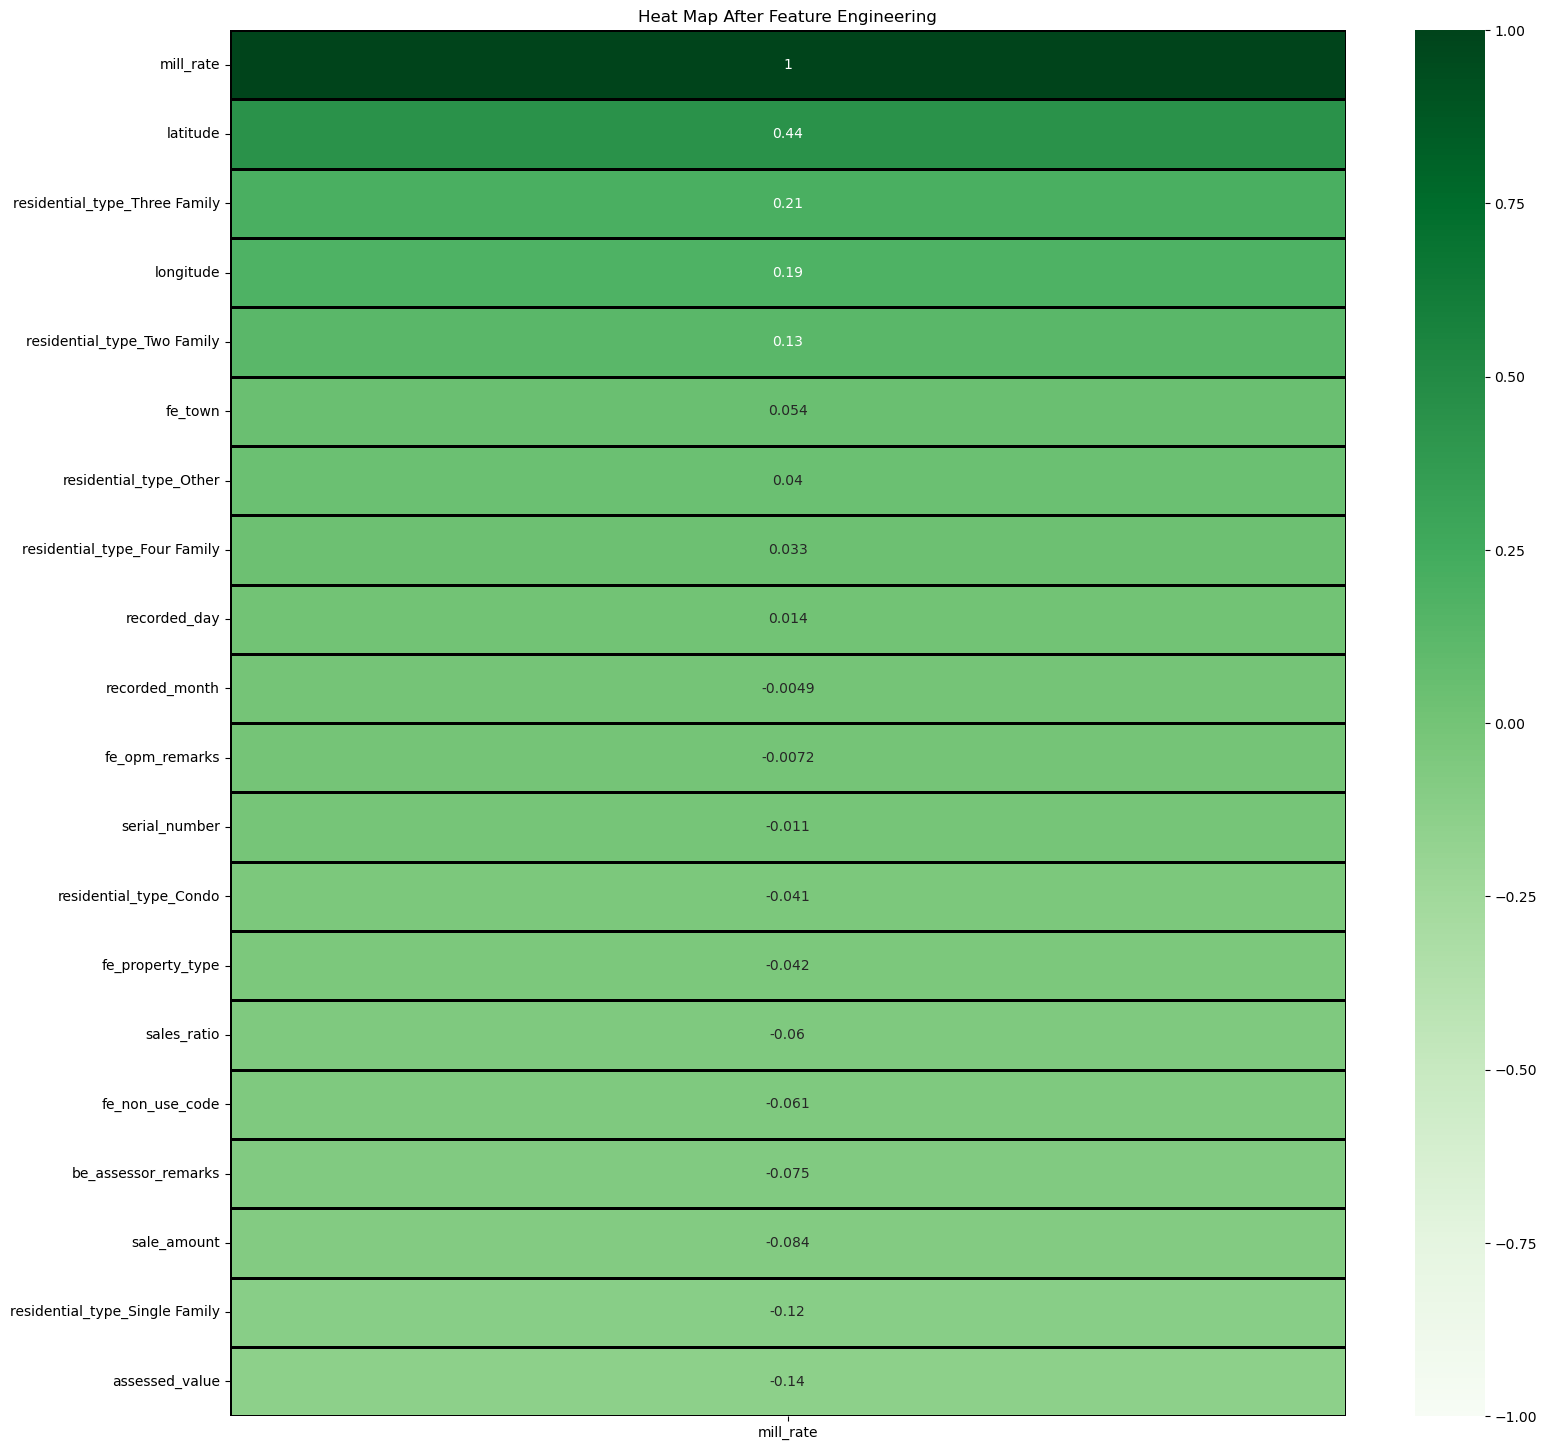

In [29]:
# Heat map of data
plt.figure(figsize=(18,18))
sns.heatmap(train.select_dtypes(include='number').corr()[['mill_rate']] \
            .sort_values(by='mill_rate', ascending=False), cmap='Greens', \
            vmin=-1, vmax=1, annot=True, linecolor='black', linewidths=2)
plt.title('Heat Map After Feature Engineering')
plt.savefig('../real_estate_value/images/heat_map_2.png');

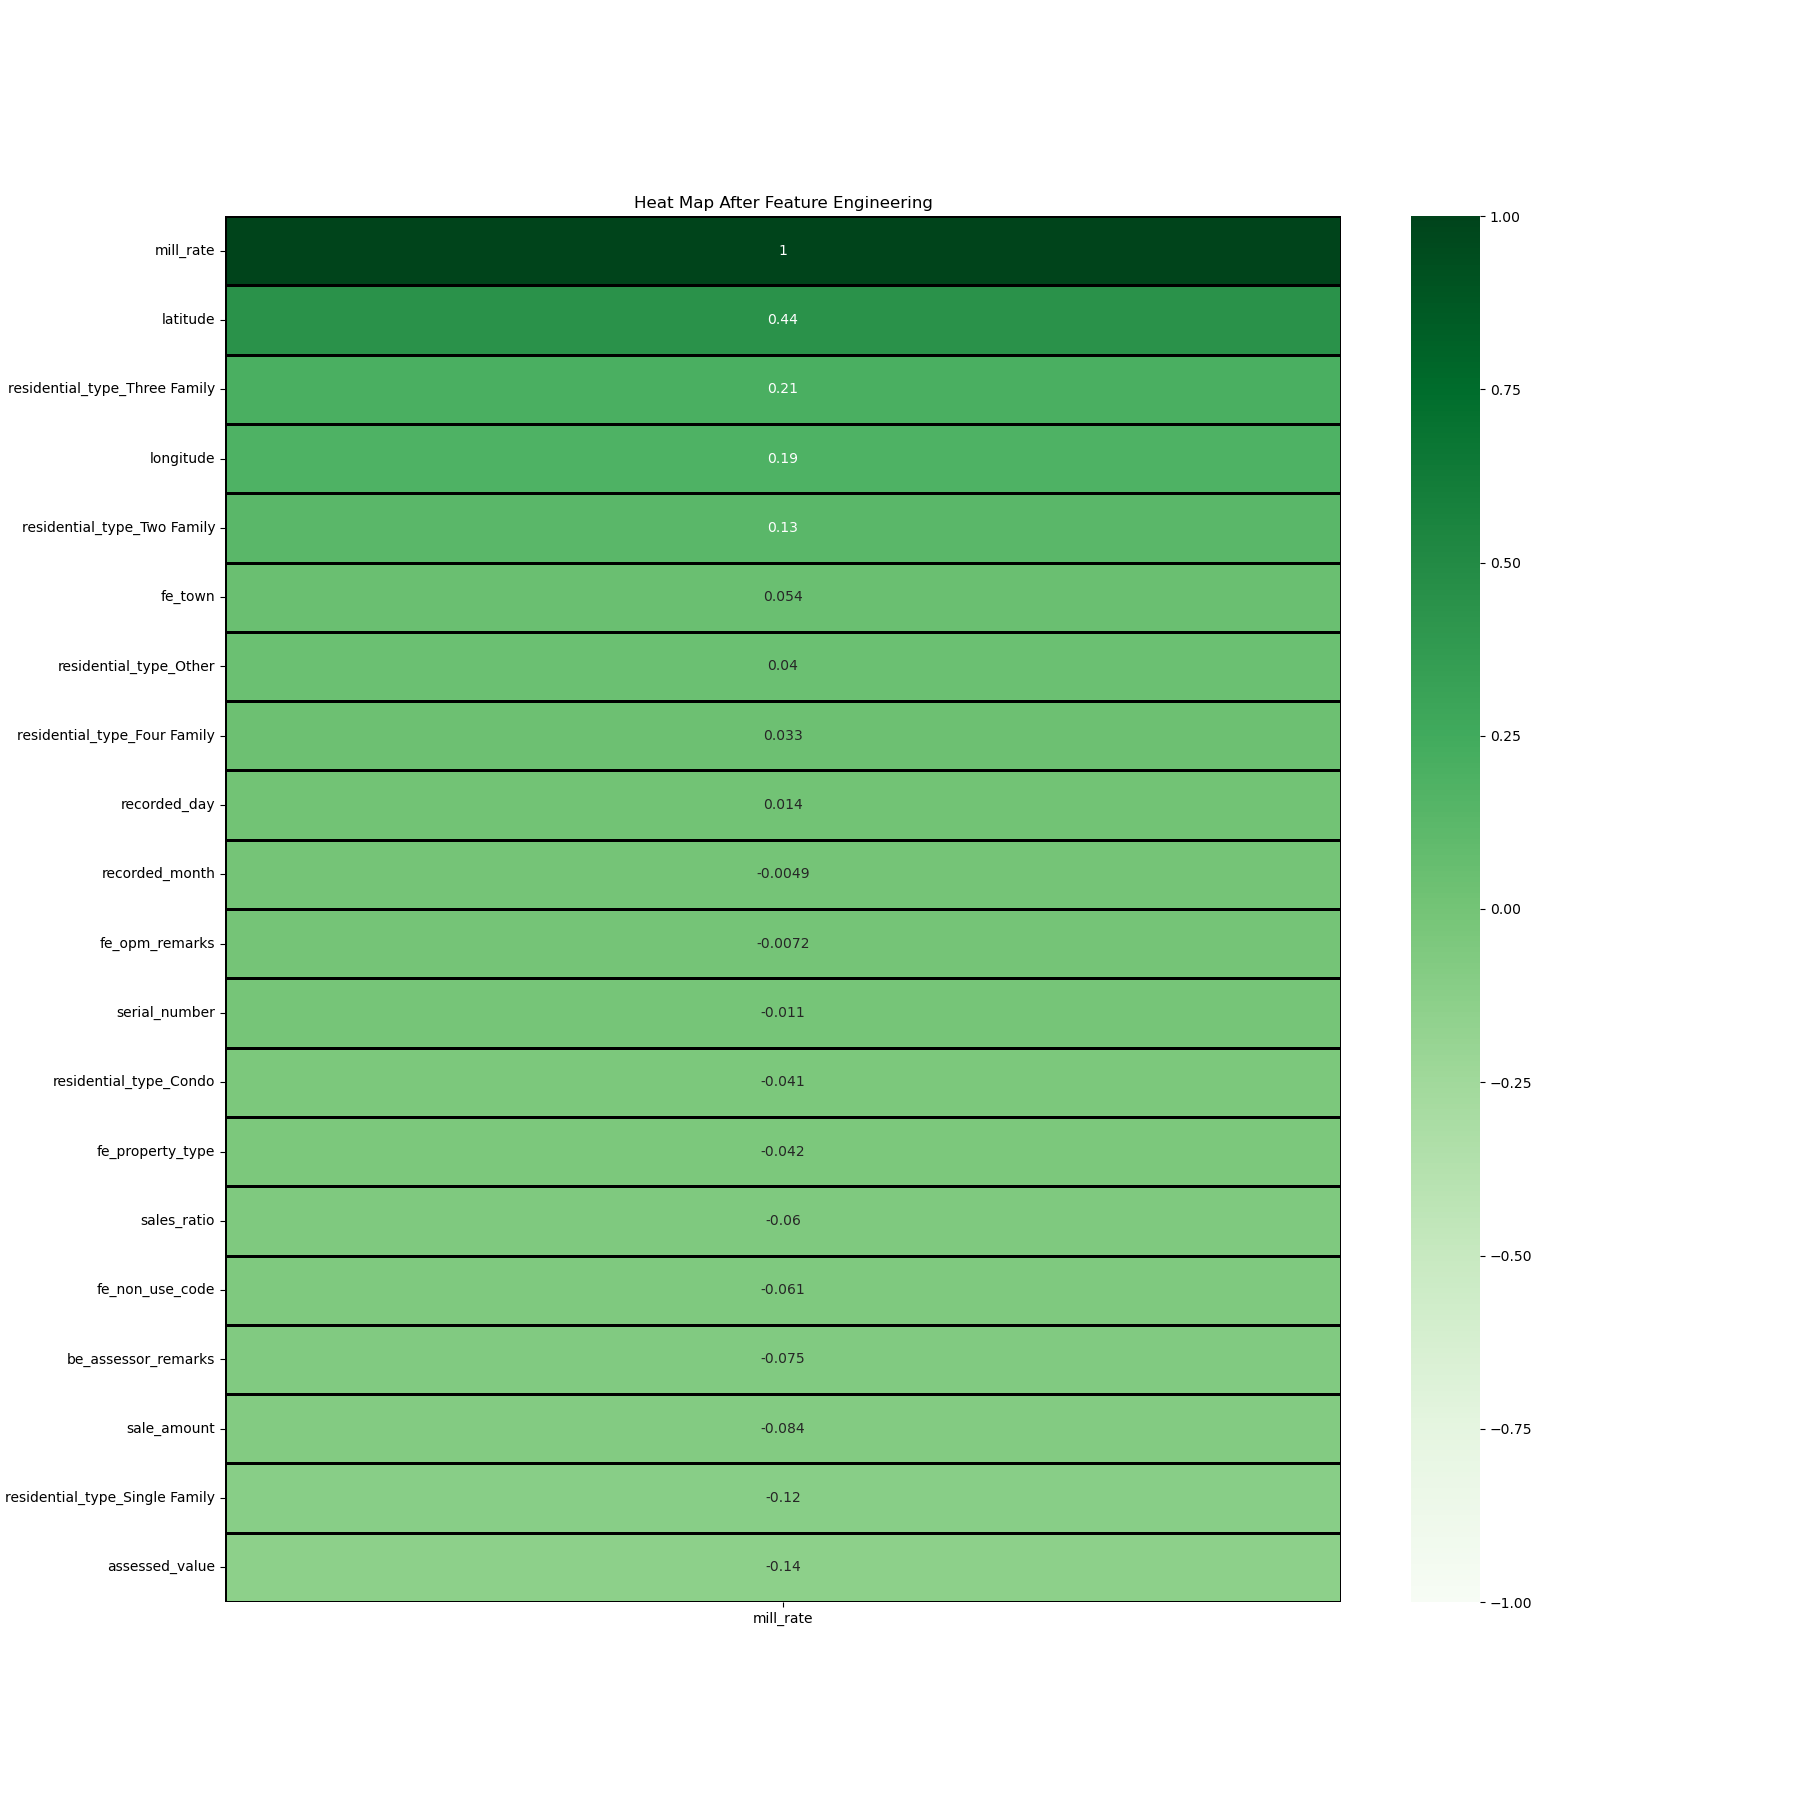

In [30]:
# View full heat map
display(Image(filename='../real_estate_value/images/heat_map_2.png'))

In [31]:
# Define a function to plot the 1-D KDE
def plot_1d_kde(col_name):
    # Set the kernel bandwidth
    sigma = math.sqrt(statistics.variance(train[col_name]))
    h = 1.06 * sigma * 90**(-1/5)

    # 1-D KDE plot
    arr = np.array(train[col_name])
    kde = KernelDensity(bandwidth=h, kernel='gaussian')
    kde.fit(arr.reshape(-1,1))
    x_val = np.linspace(np.min(arr), np.max(arr), 10)
    log_dens = kde.score_samples(x_val.reshape(-1,1))
    dens = np.exp(log_dens)
    plt.figure(figsize=(4,4))
    plt.plot(x_val, dens)
    plt.title(f'{col_name}')
    plt.show()

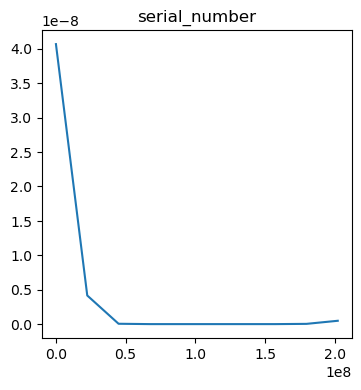

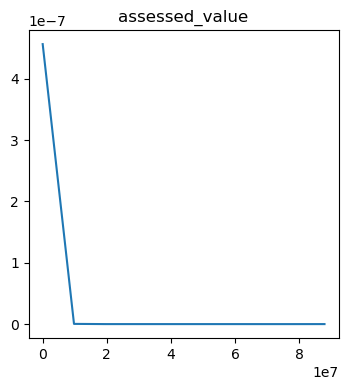

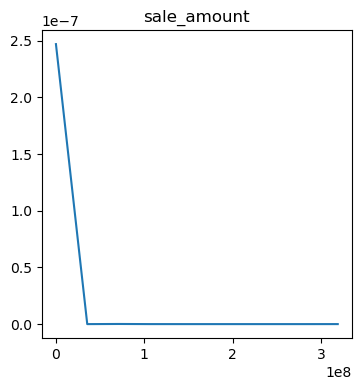

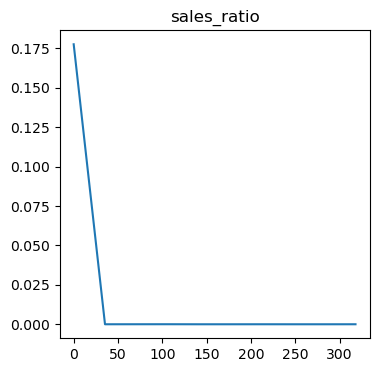

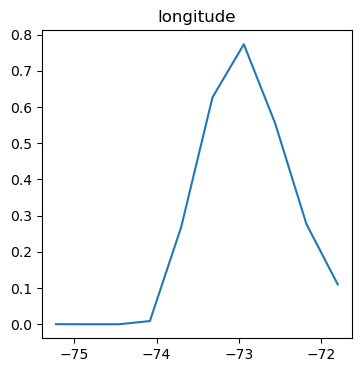

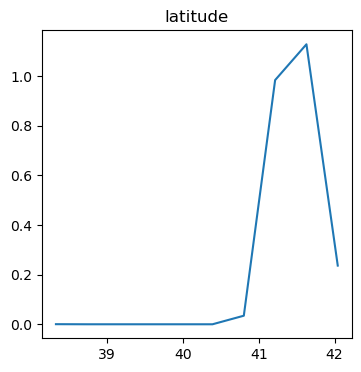

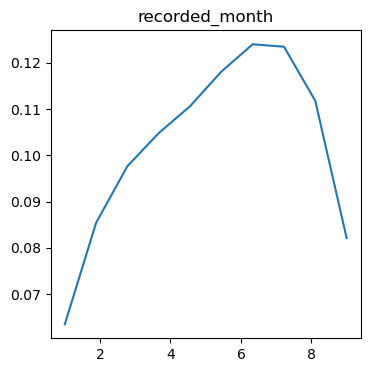

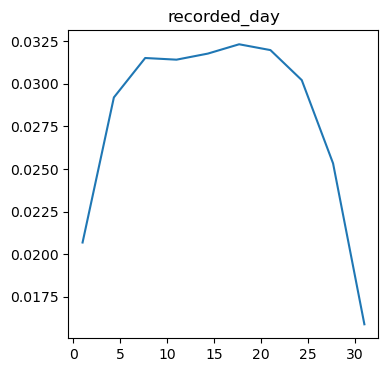

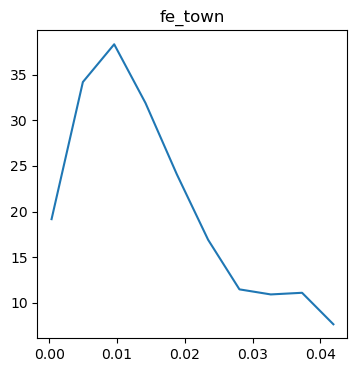

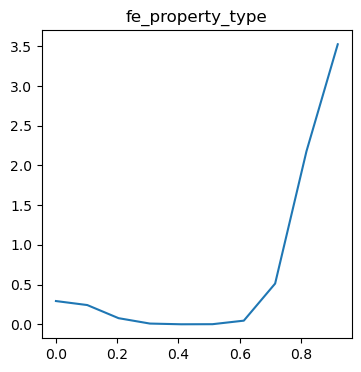

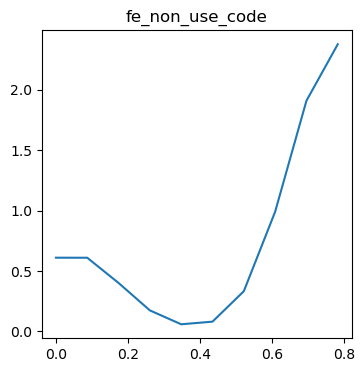

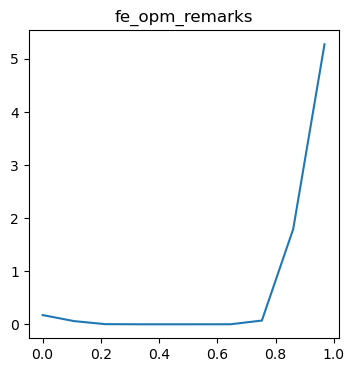

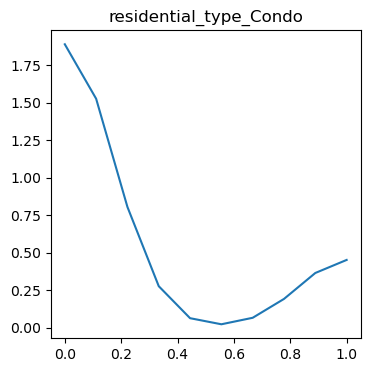

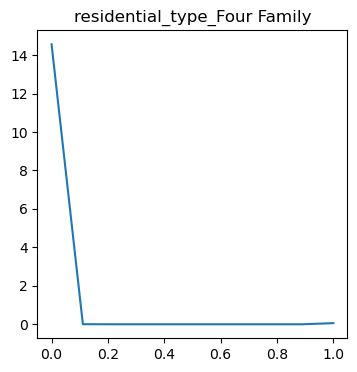

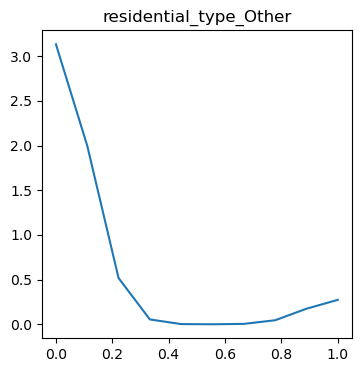

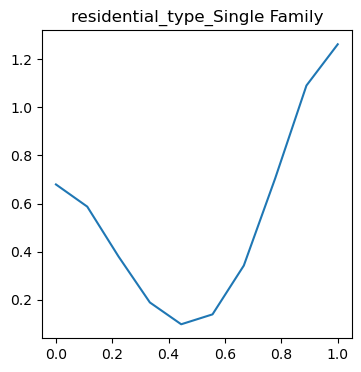

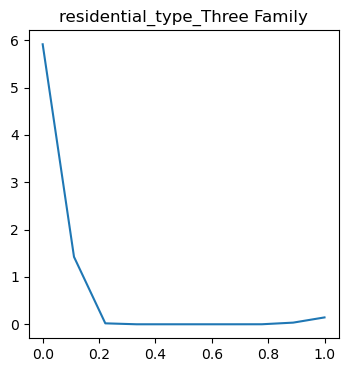

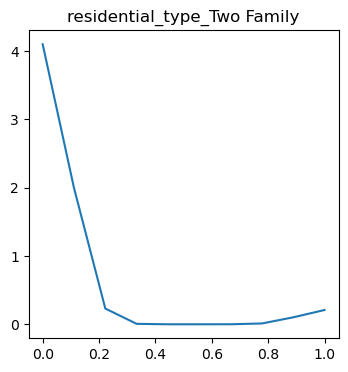

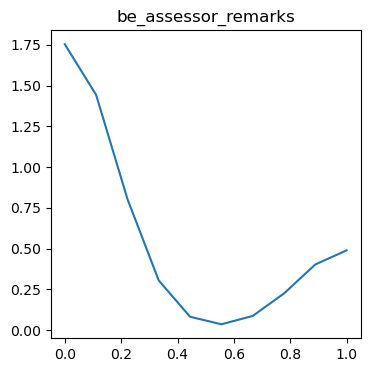

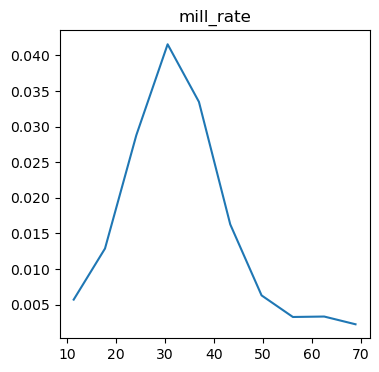

In [32]:
# Plot 1-D KDE plots for all numeric columns
for col in train.select_dtypes('number').columns:
    if col not in ['be_location', 'list_year', 'recorded_year']:
        plot_1d_kde(col)

In [33]:
# Define a function to plot 1-D histogram
def plot_1d_hist(col_name):
    # Set the bin size (square root method)
    n_bins = math.ceil(math.sqrt(len(train)))
    
    # Plot the 1-D histogram
    plt.figure(figsize=(4,4))
    plt.hist(x=train[col_name])
    plt.title(f'{col_name}')
    plt.show()

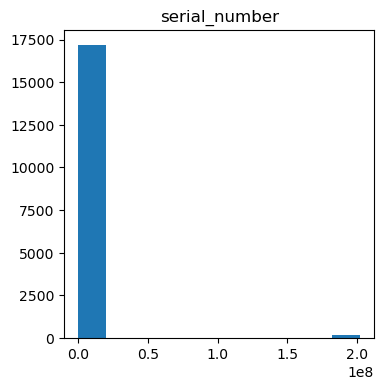

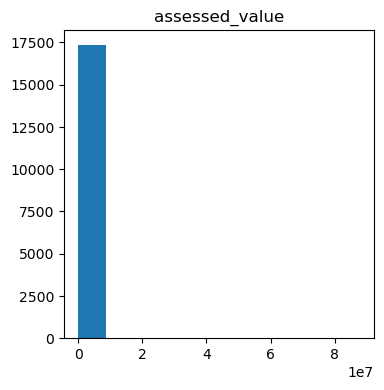

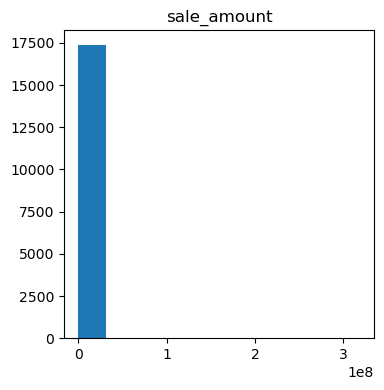

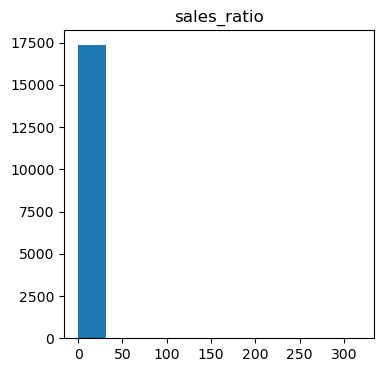

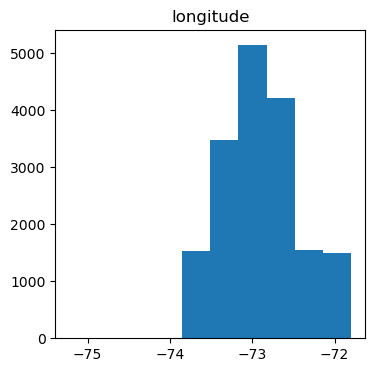

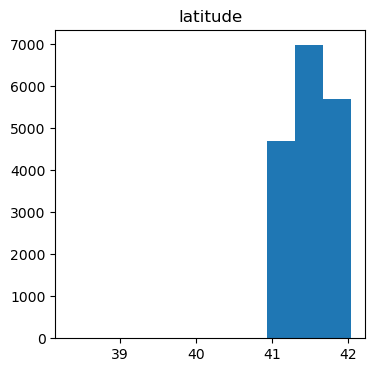

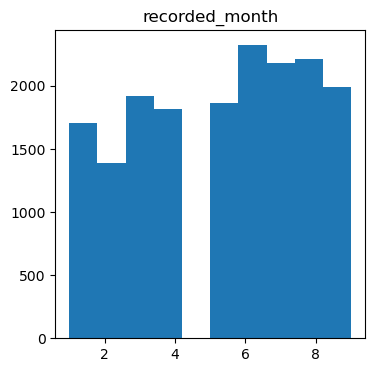

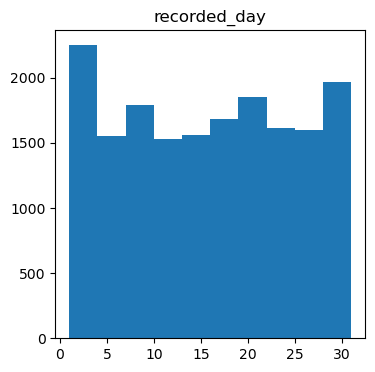

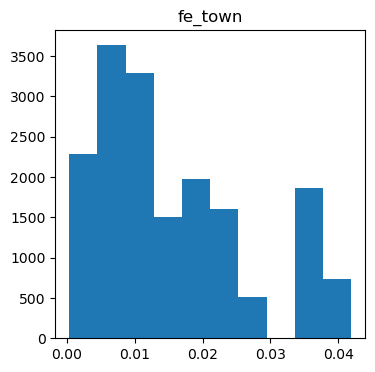

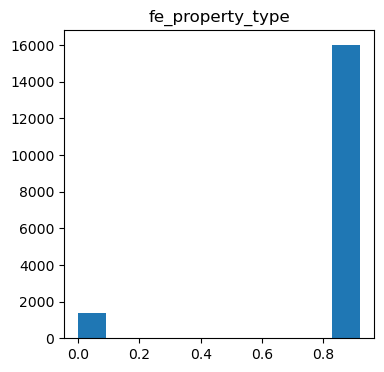

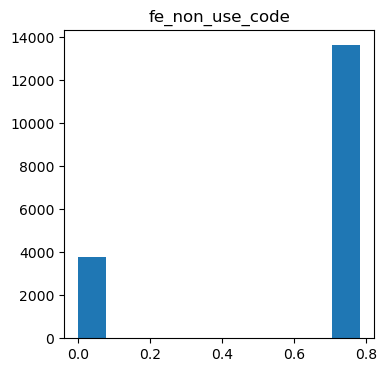

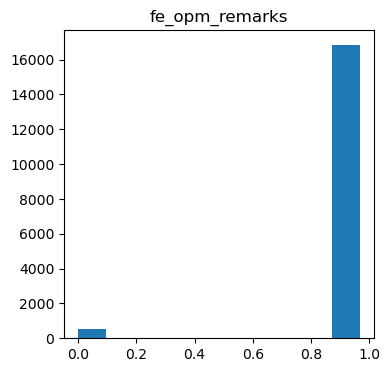

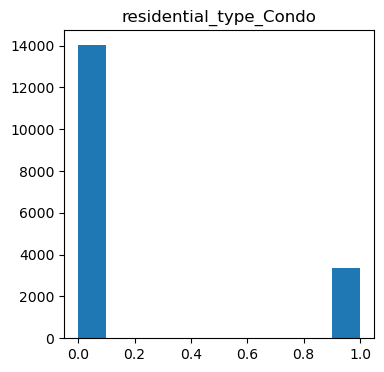

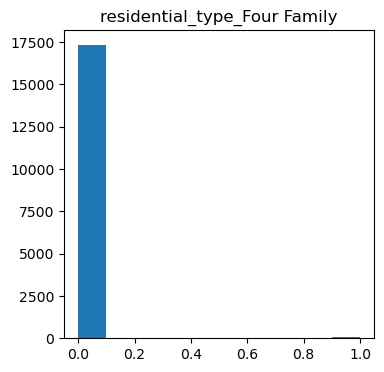

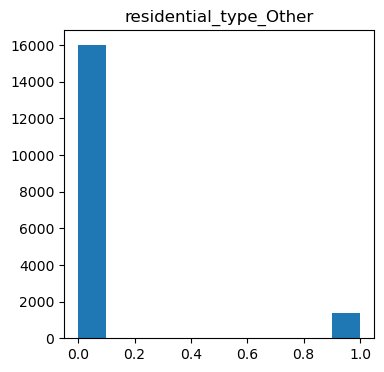

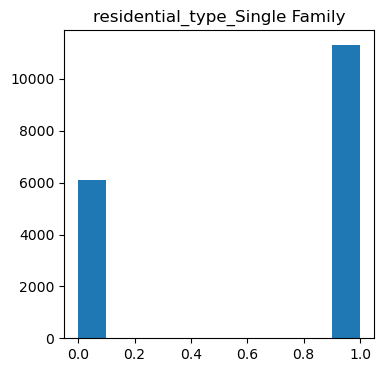

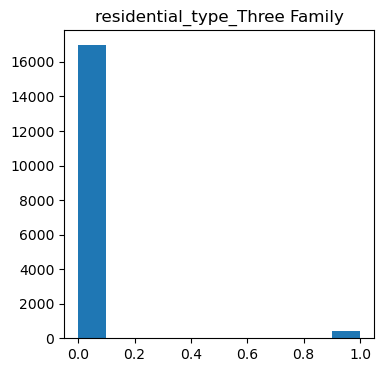

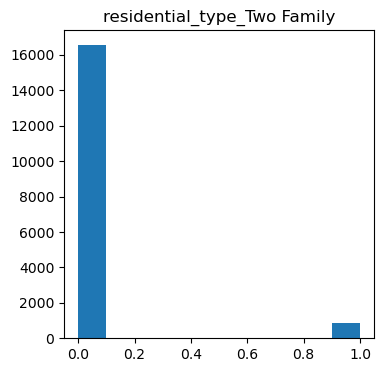

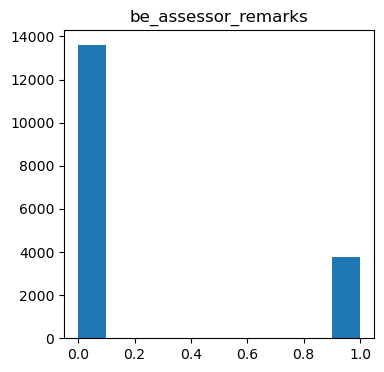

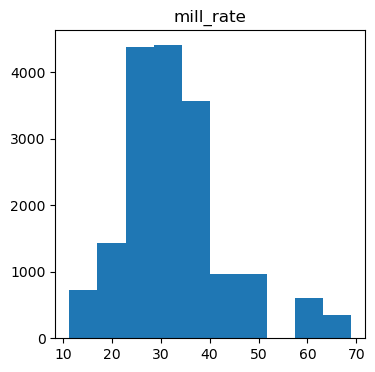

In [34]:
# Plot 1-D histogram for all numeric columns
for col in train.select_dtypes('number').columns:
    plot_1d_hist(col)

In [35]:
# Define a function to plot box plots
def plot_boxplot(col_name):
    plt.figure(figsize=(4,4))
    sns.boxplot(x=train[col_name])
    plt.title(f'{col_name}')
    plt.show()

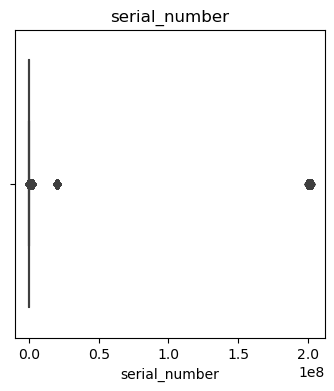

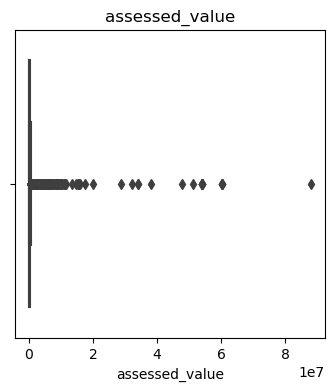

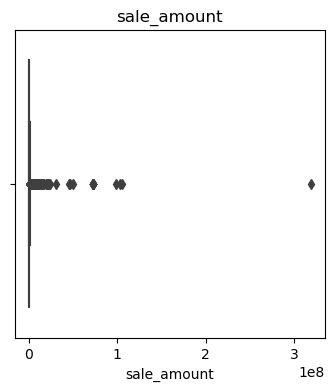

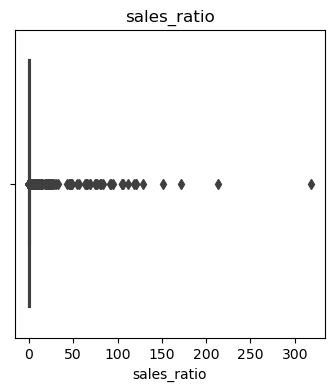

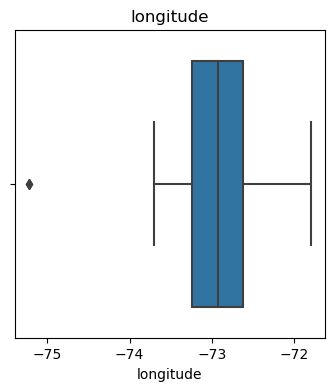

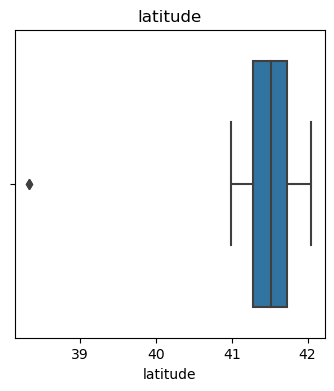

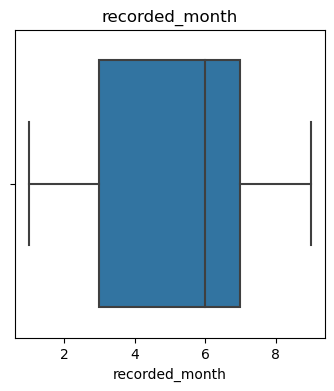

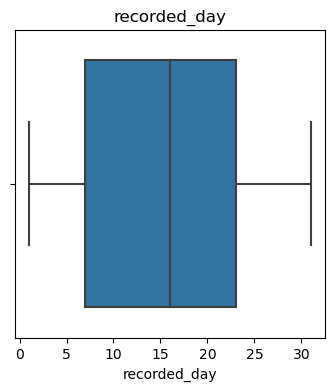

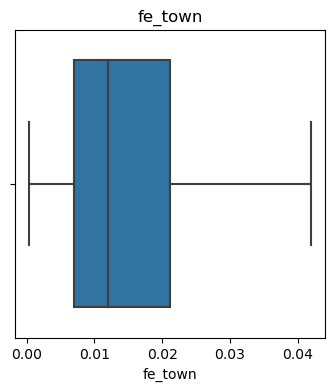

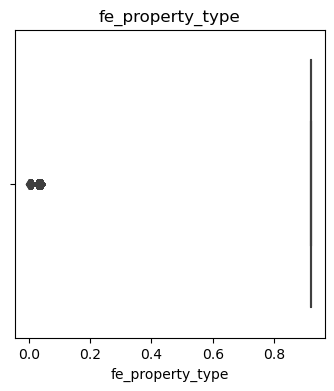

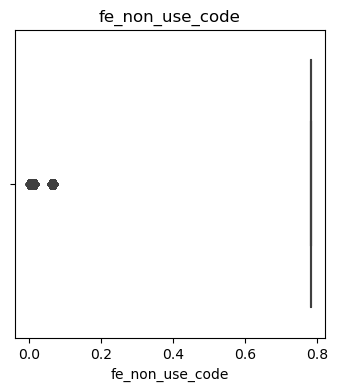

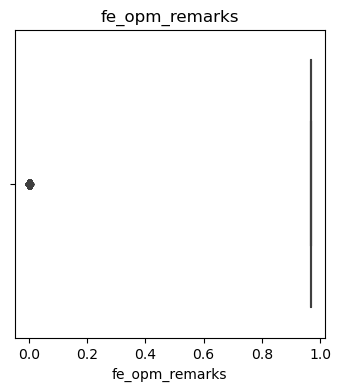

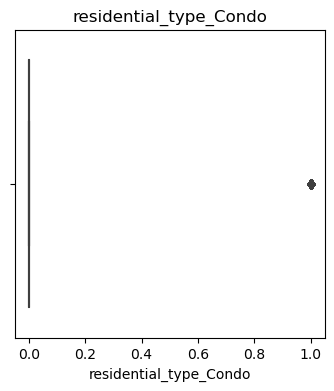

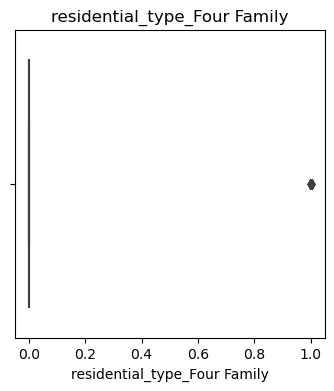

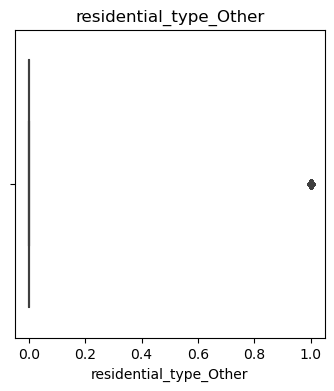

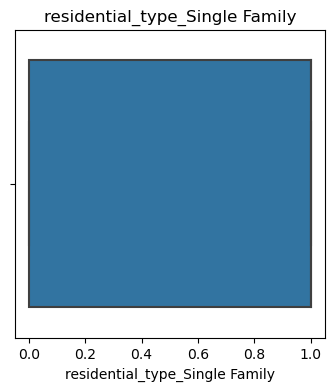

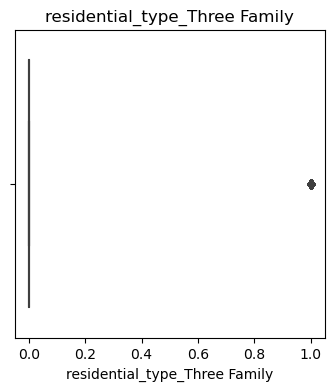

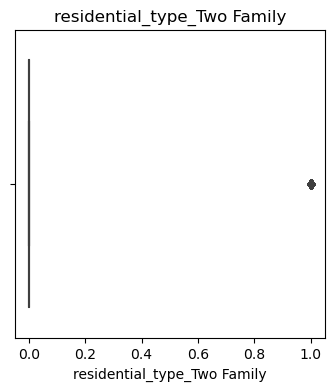

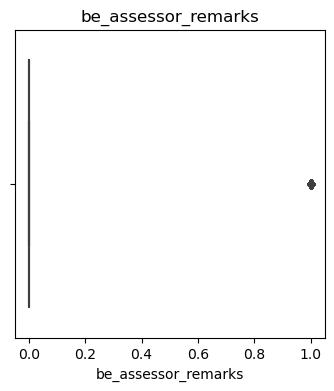

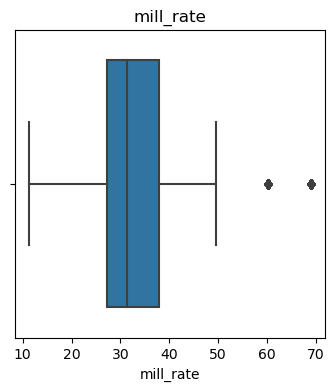

In [36]:
# Plot boxplots for all numeric columns
for col in train.select_dtypes('number').columns:
    plot_boxplot(col)

In [37]:
# Define a function to plot scatter plots - use 'mill_rate'
def plot_scatter(col_name):
    plt.figure(figsize=(4,4))
    plt.scatter(x=train[col_name], y=train['mill_rate'])
    plt.xlabel(f'{col_name}')
    plt.ylabel('mill_rate')
    plt.title(f'{col_name}')
    plt.show()

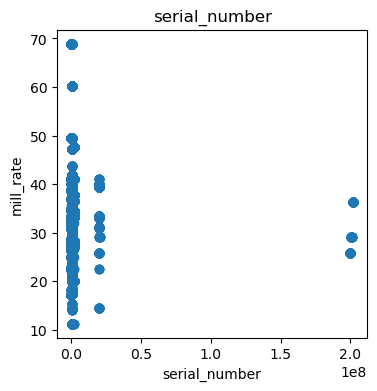

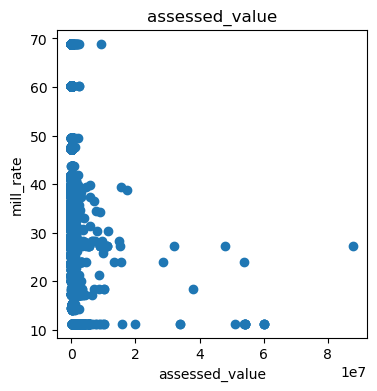

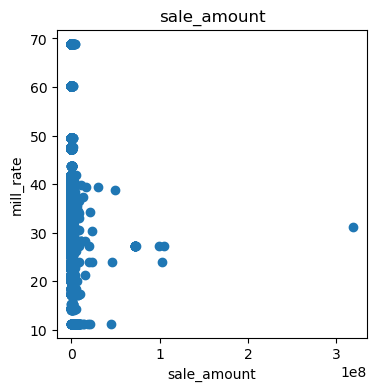

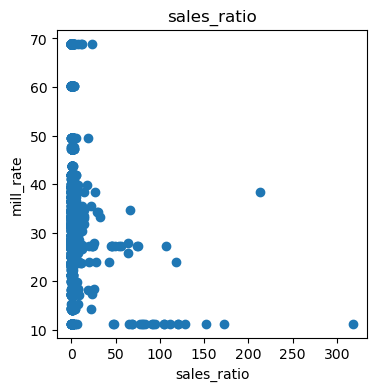

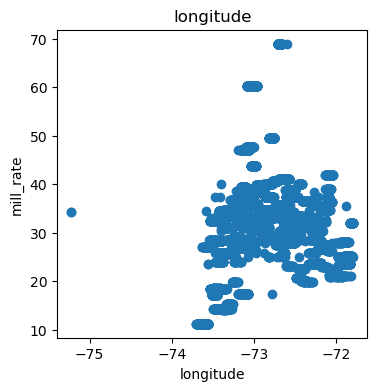

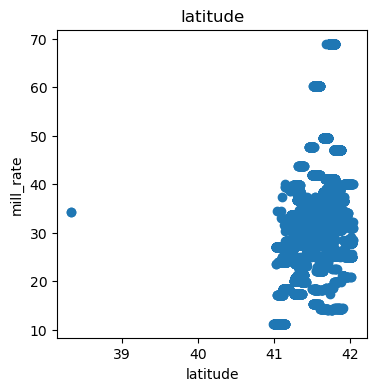

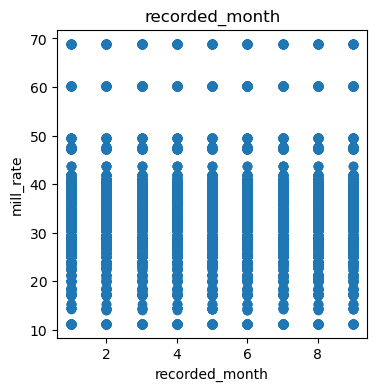

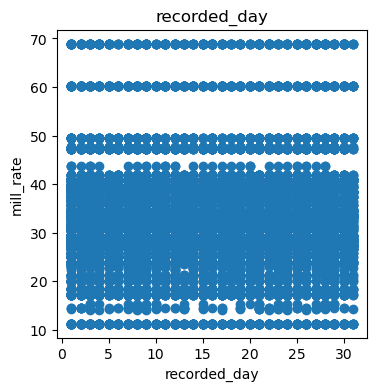

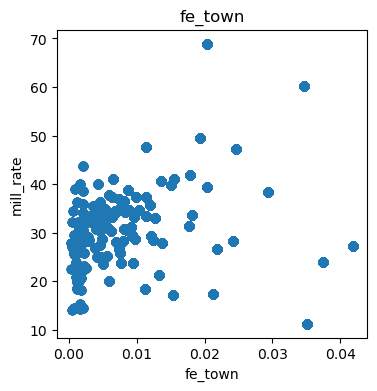

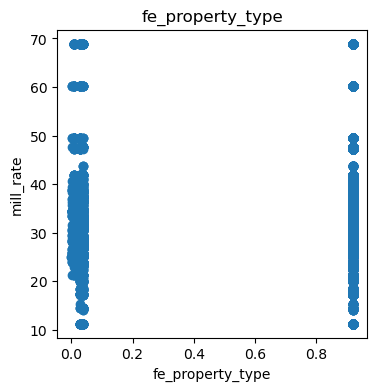

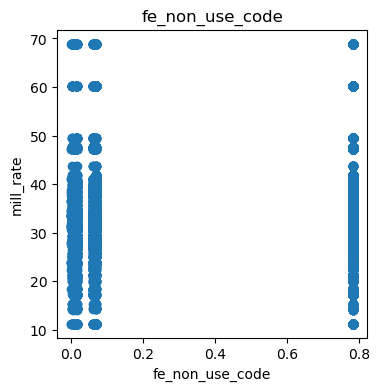

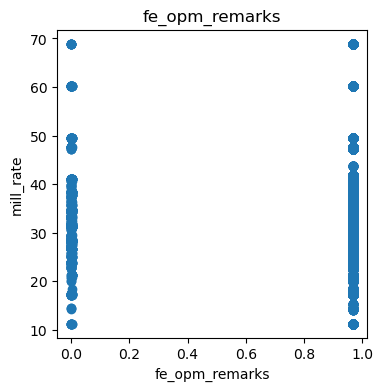

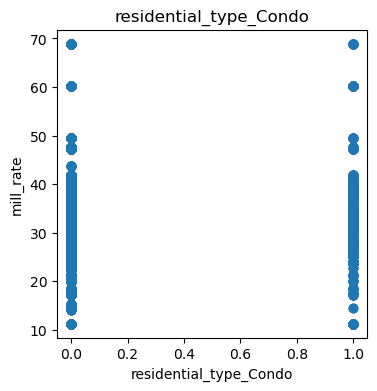

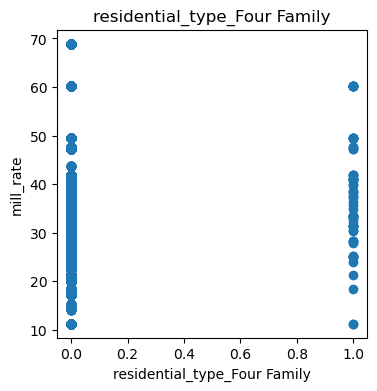

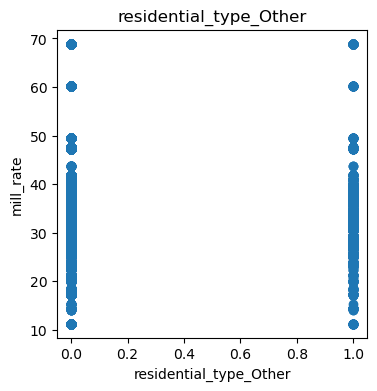

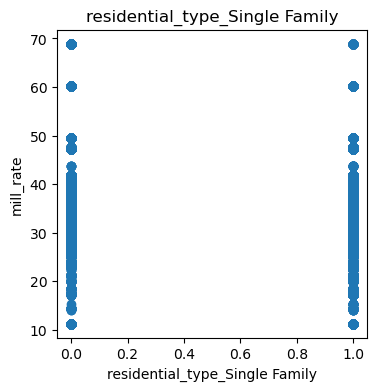

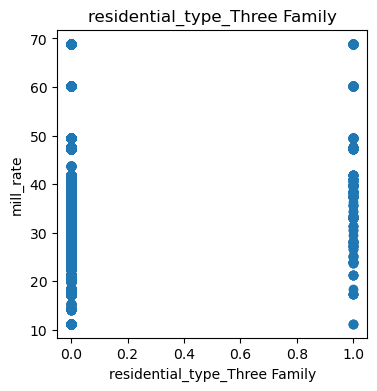

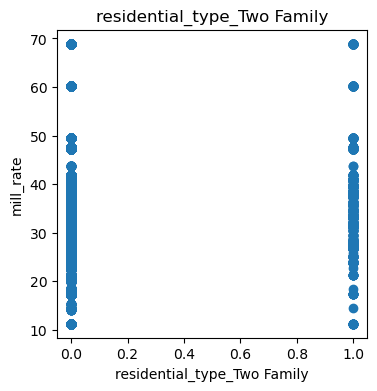

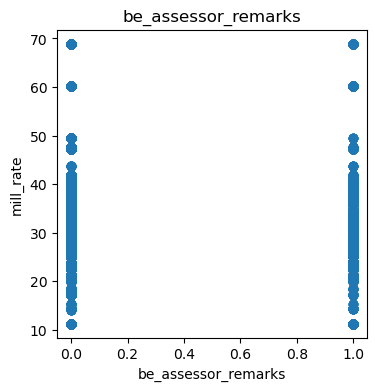

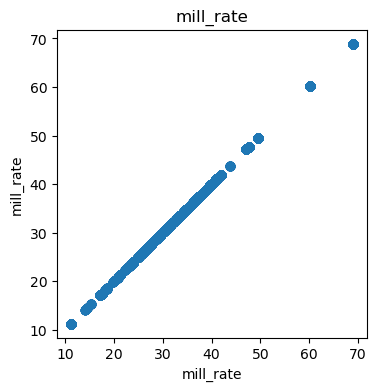

In [38]:
# Plot scatterplots for all numeric columns
for col in train.select_dtypes('number').columns:
    plot_scatter(col)

### Pre-processing

In [39]:
# None

### Supervised Learning Models with Feature Selection

In [40]:
# Imports
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor

#### The Null Model

In [41]:
# Predictions for the null model
null_preds = np.full((y_test.shape), y_train.mean())

# R-squared
null_r2 = metrics.r2_score(y_test, null_preds)
print('Null model R-squared: ', null_r2)

# MSE
null_mse = metrics.mean_squared_error(y_test, null_preds)
print('Null model MSE: ', null_mse)

Null model R-squared:  -2.7366173689813422e-05
Null model MSE:  121.55899557467255


#### Multiple Linear Regression with Recursive Feature Elimination

In [42]:
# Instantiate and fit the model
lr = LinearRegression()
lr_rfe = RFE(lr, n_features_to_select=5, step=1)
lr_rfe.fit(X_train, y_train)
rfe_Xtrain = lr_rfe.transform(X_train)
rfe_Xtest = lr_rfe.transform(X_test)
lr.fit(rfe_Xtrain, y_train)

# Cross validation score - MSE
lr_cv = cross_val_score(lr, rfe_Xtrain, y_train, 
                        scoring='neg_mean_squared_error', cv=5).mean()
print('Linear regression with RFE | CV MSE score: ', abs(lr_cv))

# Cross validation score - R2
lr_cv2 = cross_val_score(lr, rfe_Xtrain, y_train, 
                        scoring='r2', cv=5).mean()
print('Linear regression with RFE | CV r2 score: ', lr_cv2)


# Predicted y values
lr_preds = lr.predict(rfe_Xtest)

# R-squared
lr_r2 = metrics.r2_score(y_test, lr_preds)
print('Linear regression with RFE | R-squared: ', lr_r2)

# MSE
lr_mse = metrics.mean_squared_error(y_test, lr_preds)
print('Linear regression with RFE | MSE: ', lr_mse)

Linear regression with RFE | CV MSE score:  113.09778494387824
Linear regression with RFE | CV r2 score:  0.06359043882880278
Linear regression with RFE | R-squared:  0.07191394306051369
Linear regression with RFE | MSE:  112.81412159757602


#### Random Forest

In [43]:
# Instantiate random forest
rfr = RandomForestRegressor(criterion='squared_error', n_jobs=-1,
                           random_state=42)

# Cross validation score - MSE
rfr_cv = cross_val_score(rfr, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=5).mean()
print('Random forest | CV MSE score: ', abs(rfr_cv))

# Cross validation score - r2
rfr_cv2 = cross_val_score(rfr, X_train, y_train,
                        scoring='r2', cv=5).mean()
print('Random forest | CV r2 score: ', rfr_cv2)


# Parameters to search
rfr_params = {
    'n_estimators': [100, 150, 200],
    'max_features': ['sqrt', 'log2', None]
}

# Gridsearch
rfr_gs = GridSearchCV(rfr, param_grid=rfr_params, 
                      scoring='neg_mean_squared_error', cv=5)

# Model fit
rfr_gs.fit(X_train, y_train)

# Predicted y values
rfr_preds = rfr_gs.predict(X_test)

# R-squared
rfr_r2 = metrics.r2_score(y_test, rfr_preds)
print('Random forest | R-squared: ', rfr_r2)

# MSE
rfr_mse = metrics.mean_squared_error(y_test, rfr_preds)
print('Random forest | MSE: ', rfr_mse)

Random forest | CV MSE score:  0.34590345764355246
Random forest | CV r2 score:  0.997152638044372
Random forest | R-squared:  0.994134535881153
Random forest | MSE:  0.7129804153204411


In [44]:
# Best parameters
rfr_gs.best_estimator_

RandomForestRegressor(max_features=None, n_estimators=150, n_jobs=-1,
                      random_state=42)

In [45]:
# Instantiate random forest
best_rfr = RandomForestRegressor(max_features=None, n_estimators=150, 
                                 n_jobs=-1, random_state=42)

# Model fit
best_rfr.fit(X_train, y_train)

# Predicted y values
best_rfr_preds = best_rfr.predict(X_test)

# R-squared
best_rfr_r2 = metrics.r2_score(y_test, best_rfr_preds)
print('Best random forest | R-squared: ', best_rfr_r2)

# MSE
best_rfr_mse = metrics.mean_squared_error(y_test, best_rfr_preds)
print('Best random forest | MSE: ', best_rfr_mse)

Best random forest | R-squared:  0.994134535881153
Best random forest | MSE:  0.7129804153204409


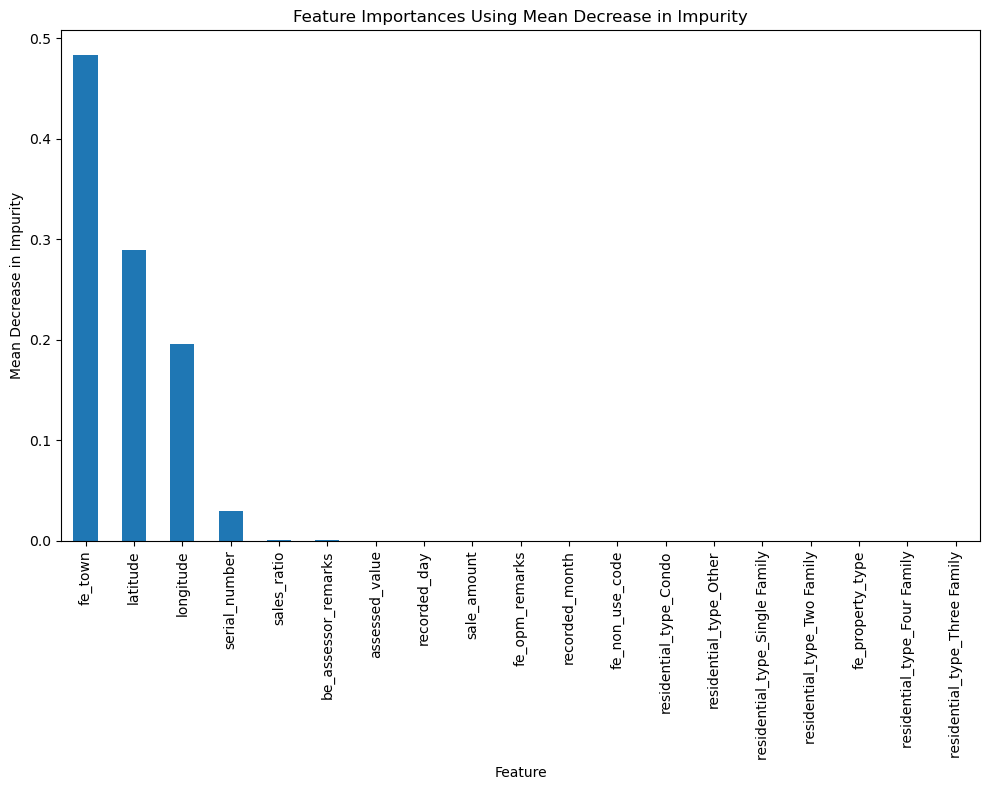

In [46]:
# Plot feature importances
features = list(X_train.columns)
importances = best_rfr.feature_importances_
best_rfr_importances = pd.Series(importances, index=features)
sorted_best_rfr_importances = best_rfr_importances.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,8))
sorted_best_rfr_importances.plot.bar(ax=ax)
ax.set_title("Feature Importances Using Mean Decrease in Impurity")
ax.set_ylabel("Mean Decrease in Impurity")
ax.set_xlabel("Feature")
fig.tight_layout()

#### Neural Network: Multi-Layer Perceptron (MLP) Regressor

In [47]:
# Instantiate MLP
mlp = MLPRegressor(activation='relu', solver='adam', batch_size='auto',                   
                   learning_rate='constant', learning_rate_init=0.001, 
                   alpha=0.0001, power_t=0.5, shuffle=True,
                   random_state=42, tol=0.0001, verbose=False, 
                   warm_start=False, momentum=0.9, nesterovs_momentum=True,
                   early_stopping=False, validation_fraction=0.1,
                   beta_1=0.9, beta_2=0.999, epsilon=1e-08)

# Cross validation score - MSE
mlp_cv = cross_val_score(mlp, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=5).mean()
print('MLP regressor | CV MSE score: ', abs(mlp_cv))

# Cross validation score - r2
mlp_cv2 = cross_val_score(mlp, X_train, y_train,
                        scoring='r2', cv=5).mean()
print('MLP regressor | CV r2 score: ', mlp_cv2)

# Parameters to search
mlp_params = {
    'hidden_layer_sizes': [(10,10), (10,10,10), (50,25,10)],
    'max_iter': [500,1000]
}

# Gridsearch
mlp_gs = GridSearchCV(mlp, param_grid=mlp_params, 
                      scoring='neg_mean_squared_error', cv=5)

# Model fit
mlp_gs.fit(X_train, y_train)

# Predicted y values
mlp_preds = mlp_gs.predict(X_test)

# R-squared
mlp_r2 = metrics.r2_score(y_test, mlp_preds)
print('MLP regressor | R-squared: ', mlp_r2)

# MSE
mlp_mse = metrics.mean_squared_error(y_test, mlp_preds)
print('MLP regressor | MSE: ', mlp_mse)

MLP regressor | CV MSE score:  1483471593.0985546
MLP regressor | CV r2 score:  -12172133.331716502
MLP regressor | R-squared:  -13748.682181786291
MLP regressor | MSE:  1671351.8169847936


In [48]:
# Best parameters
mlp_gs.best_estimator_

MLPRegressor(hidden_layer_sizes=(10, 10, 10), max_iter=500, random_state=42)

#### KNN

In [49]:
# Instantiate KNN
knn = KNeighborsRegressor()

# Cross validation score - MSE
knn_cv = cross_val_score(knn, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=5).mean()
print('KNN | CV MSE score: ', abs(knn_cv))

# Cross validation score - r2
knn_cv2 = cross_val_score(knn, X_train, y_train,
                        scoring='r2', cv=5).mean()
print('KNN | CV r2 score: ', knn_cv2)

# Set up pipeline
knn_pipe = Pipeline([
    ('ss', StandardScaler()),
    ('knn', KNeighborsRegressor())
])

# Set up grid parameters
knn_params = {'knn__n_neighbors': [5, 7, 9, 11, 13],
              'knn__weights': ['uniform', 'distance'],
             'knn__p': [1, 2],
              'knn__n_jobs': [-1],
              'knn__metric': ['minkowski']
             }

# Instantiate gridsearch
knn_gs = GridSearchCV(estimator=knn_pipe,
                     param_grid=knn_params,
                      scoring='neg_mean_squared_error',
                     cv=5)

# Fit model
knn_gs.fit(X_train, y_train)

# Predicted y values
knn_preds = knn_gs.predict(X_test)

# R-squared
knn_r2 = metrics.r2_score(y_test, knn_preds)
print('KNN | R-squared: ', knn_r2)

# MSE
knn_mse = metrics.mean_squared_error(y_test, knn_preds)
print('KNN | MSE: ', knn_mse)

KNN | CV MSE score:  89.41472217913328
KNN | CV r2 score:  0.2594511551982005
KNN | R-squared:  0.8980867651518365
KNN | MSE:  12.388131448151578


In [50]:
# Best parameters
knn_gs.best_params_

{'knn__metric': 'minkowski',
 'knn__n_jobs': -1,
 'knn__n_neighbors': 5,
 'knn__p': 1,
 'knn__weights': 'distance'}

### Results

**R-squared + MSE targets:**
- Beat the null model
- Null model R-squared:  -2.751069446893517e-05
- Null model MSE:  109.70661600775259